# Ensemble Methods — Random Forests

This notebook demonstrates **bagging** and **random forests** using our NumPy-only implementations in `rice_ml.supervised_learning.ensemble_methods`.

We focus on two ideas:
- **Bagging reduces variance** by averaging many high-variance learners (decision trees).
- **Random feature subsampling** (`max_features`) decorrelates trees, improving the ensemble.

We use two classification datasets (Iris 2D and Breast Cancer) and two regression datasets (Diabetes and a 1D synthetic example).

## 1. Set-up

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

def add_repo_src_to_path(max_up: int = 8) -> None:
    cur = os.path.abspath(os.getcwd())
    for _ in range(max_up):
        candidate = os.path.join(cur, "src")
        if os.path.isdir(os.path.join(candidate, "rice_ml")):
            if candidate not in sys.path:
                sys.path.insert(0, candidate)
            return
        cur = os.path.abspath(os.path.join(cur, ".."))
    raise RuntimeError("Could not find 'src/rice_ml'. Run this notebook inside the repo, or install the package.")

add_repo_src_to_path()

from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.supervised_learning.decision_trees import DecisionTreeClassifier
from rice_ml.supervised_learning.regression_trees import RegressionTreeRegressor
from rice_ml.supervised_learning.ensemble_methods import RandomForestClassifier, RandomForestRegressor

from sklearn.datasets import load_iris, load_breast_cancer, load_diabetes

np.set_printoptions(precision=4, suppress=True)


## 2. Helper metrics + plotting

In [2]:
def accuracy(y_true, y_pred) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(y_true == y_pred))

def rmse(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def r2_score(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot == 0:
        return 0.0
    return float(1.0 - ss_res / ss_tot)

def confusion_matrix_np(y_true, y_pred, labels=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    labels = np.asarray(labels)
    k = labels.size
    cm = np.zeros((k, k), dtype=int)
    for i, a in enumerate(labels):
        for j, b in enumerate(labels):
            cm[i, j] = int(np.sum((y_true == a) & (y_pred == b)))
    return cm, labels

def plot_decision_regions_2d(
    X_raw,
    y,
    clf,
    title: str,
    xlabel: str,
    ylabel: str,
    mean=None,
    scale=None,
    h: float = 0.02,
):
    """Plot decision regions in the *raw* 2D feature space.

    If `mean` and `scale` are provided, the grid points are standardized
    before being passed to the classifier (useful when the model was fit
    on standardized features, but we want axes in original units).
    """
    X_raw = np.asarray(X_raw)
    y = np.asarray(y)

    x_min, x_max = X_raw[:, 0].min() - 0.6, X_raw[:, 0].max() + 0.6
    y_min, y_max = X_raw[:, 1].min() - 0.6, X_raw[:, 1].max() + 0.6

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_raw = np.c_[xx.ravel(), yy.ravel()]

    grid = grid_raw
    if mean is not None and scale is not None:
        grid = (grid_raw - mean) / scale

    Z = clf.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y, edgecolor="k", s=25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


## 3. Part A — Classification (Iris, 2D)

We use **petal length** and **petal width** (2D) to visualize decision boundaries.

In [3]:
iris = load_iris()
X2 = iris.data[:, [2, 3]]  # petal length, petal width
y = iris.target

print("X2 shape:", X2.shape)
print("y shape :", y.shape)
print("classes :", list(enumerate(iris.target_names)))
unique, counts = np.unique(y, return_counts=True)
print("class counts:", dict(zip(unique, counts)))


X2 shape: (150, 2)
y shape : (150,)
classes : [(0, np.str_('setosa')), (1, np.str_('versicolor')), (2, np.str_('virginica'))]
class counts: {np.int64(0): np.int64(50), np.int64(1): np.int64(50), np.int64(2): np.int64(50)}


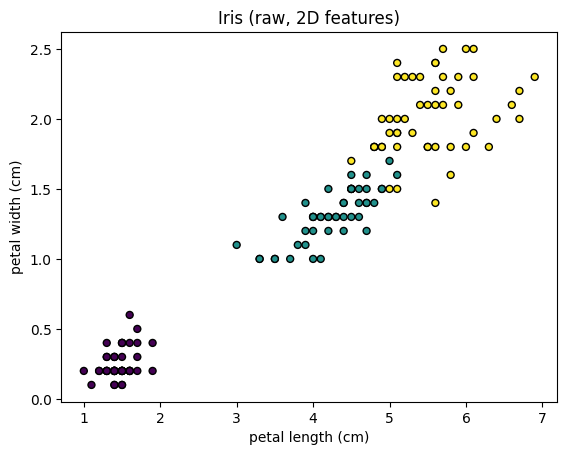

In [4]:
plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], c=y, edgecolor="k", s=25)
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.title("Iris (raw, 2D features)")
plt.show()


### 3.1 Train/test split + standardization

Trees/forests do **not** require feature scaling, but we keep a consistent preprocessing workflow and later verify that scaling does not change predictions (with fixed seeds).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X2, y,
    test_size=0.25,
    shuffle=True,
    stratify=y,
    random_state=42,
)

X_train_std, params = standardize(X_train, return_params=True)
mean = params["mean"]
scale = params["scale"]
X_test_std = (X_test - mean) / scale

print("Train mean (approx):", np.round(X_train_std.mean(axis=0), 6))
print("Train std  (approx):", np.round(X_train_std.std(axis=0), 6))
print("Test  mean (approx):", np.round(X_test_std.mean(axis=0), 6))
print("Test  std  (approx):", np.round(X_test_std.std(axis=0), 6))


Train mean (approx): [-0.  0.]
Train std  (approx): [1. 1.]
Test  mean (approx): [ 0.0044 -0.0367]
Test  std  (approx): [0.9701 0.9266]


### 3.2 Fit a Random Forest and visualize decision regions

In [6]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=3,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    random_state=42,
).fit(X_train_std, y_train)

train_acc = accuracy(y_train, rf.predict(X_train_std))
test_acc = accuracy(y_test, rf.predict(X_test_std))

print("RandomForestClassifier (Iris 2D) | max_depth=3")
print("  train acc:", train_acc)
print("  test  acc:", test_acc)

y_pred = rf.predict(X_test_std)
cm, labels = confusion_matrix_np(y_test, y_pred, labels=[0, 1, 2])
print("\nConfusion matrix (test): rows=true, cols=pred, labels=[0,1,2]")
print(cm)


RandomForestClassifier (Iris 2D) | max_depth=3
  train acc: 0.9824561403508771
  test  acc: 0.9166666666666666

Confusion matrix (test): rows=true, cols=pred, labels=[0,1,2]
[[12  0  0]
 [ 0 11  1]
 [ 0  2 10]]


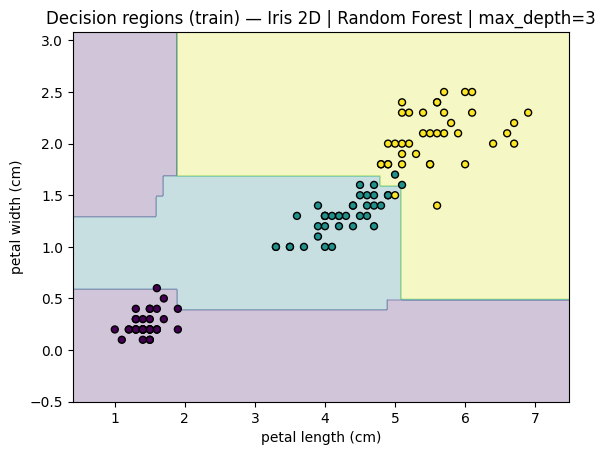

In [7]:
plot_decision_regions_2d(
    X_train, y_train, rf,
    title="Decision regions (train) — Iris 2D | Random Forest | max_depth=3",
    xlabel="petal length (cm)",
    ylabel="petal width (cm)",
    mean=mean,
    scale=scale,
)


### 3.3 Scaling check: raw vs standardized

We fit the same forest twice (same `random_state`) on raw vs standardized features and compare predictions on the **test set**.

In [8]:
rf_raw = RandomForestClassifier(
    n_estimators=200,
    max_depth=3,
    max_features="sqrt",
    bootstrap=True,
    random_state=42,
).fit(X_train, y_train)

rf_std = RandomForestClassifier(
    n_estimators=200,
    max_depth=3,
    max_features="sqrt",
    bootstrap=True,
    random_state=42,
).fit(X_train_std, y_train)

pred_raw = rf_raw.predict(X_test)
pred_std = rf_std.predict(X_test_std)

print("Test accuracy (raw features):", accuracy(y_test, pred_raw))
print("Test accuracy (standardized):", accuracy(y_test, pred_std))
print("Predictions identical?      :", bool(np.array_equal(pred_raw, pred_std)))


Test accuracy (raw features): 0.9166666666666666
Test accuracy (standardized): 0.9166666666666666
Predictions identical?      : True


### 3.4 Hyperparameter sweeps (Iris 2D)

We scan `max_depth` and `n_estimators` to see the bias–variance pattern in classification.

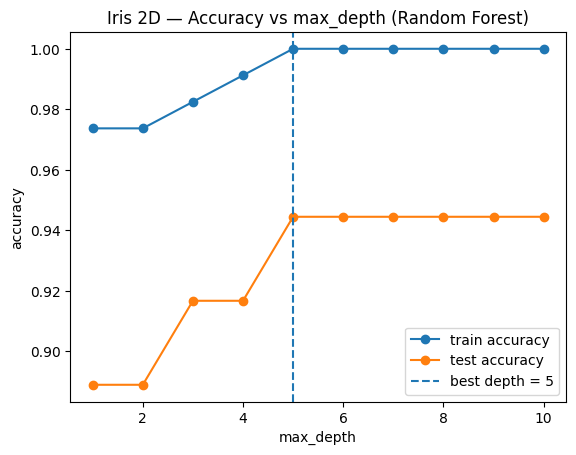

Best depth by test accuracy: 5


In [9]:
depths = list(range(1, 11))
train_accs = []
test_accs = []

for d in depths:
    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=d,
        max_features="sqrt",
        bootstrap=True,
        random_state=42,
    ).fit(X_train_std, y_train)
    train_accs.append(accuracy(y_train, clf.predict(X_train_std)))
    test_accs.append(accuracy(y_test, clf.predict(X_test_std)))

best_d = depths[int(np.argmax(test_accs))]

plt.figure()
plt.plot(depths, train_accs, marker="o", label="train accuracy")
plt.plot(depths, test_accs, marker="o", label="test accuracy")
plt.axvline(best_d, linestyle="--", label=f"best depth = {best_d}")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Iris 2D — Accuracy vs max_depth (Random Forest)")
plt.legend()
plt.show()

print("Best depth by test accuracy:", best_d)


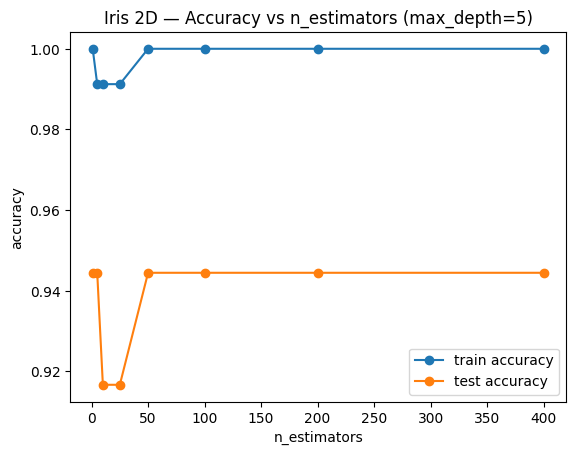

In [10]:
n_list = [1, 5, 10, 25, 50, 100, 200, 400]
train_accs_n = []
test_accs_n = []

for n_estimators in n_list:
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=best_d,
        max_features="sqrt",
        bootstrap=True,
        random_state=42,
    ).fit(X_train_std, y_train)
    train_accs_n.append(accuracy(y_train, clf.predict(X_train_std)))
    test_accs_n.append(accuracy(y_test, clf.predict(X_test_std)))

plt.figure()
plt.plot(n_list, train_accs_n, marker="o", label="train accuracy")
plt.plot(n_list, test_accs_n, marker="o", label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.title(f"Iris 2D — Accuracy vs n_estimators (max_depth={best_d})")
plt.legend()
plt.show()


In [11]:
settings = [
    ("all (None)", None),
    ("sqrt(p)", "sqrt"),
    ("0.3*p", 0.3),
]

rows = []
for name, mf in settings:
    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=best_d,
        max_features=mf,
        bootstrap=True,
        random_state=42,
    ).fit(X_train_std, y_train)
    rows.append([
        name,
        mf,
        accuracy(y_train, clf.predict(X_train_std)),
        accuracy(y_test, clf.predict(X_test_std)),
    ])

print("setting\tmax_features\ttrain_acc\ttest_acc")
for r in rows:
    print(f"{r[0]}\t{r[1]}\t{r[2]:.4f}\t{r[3]:.4f}")


setting	max_features	train_acc	test_acc
all (None)	None	1.0000	0.9167
sqrt(p)	sqrt	1.0000	0.9444
0.3*p	0.3	1.0000	0.9444


## 4. Part B — Classification (Breast Cancer, 30D)

We compare a **single decision tree** vs a **random forest** on a higher-dimensional dataset.

In [12]:
data = load_breast_cancer()
X = data.data
y = data.target  # {0,1}

print("X shape:", X.shape)
print("y shape:", y.shape)
print("classes:", list(enumerate(data.target_names)))
unique, counts = np.unique(y, return_counts=True)
print("class counts:", dict(zip(unique, counts)))
print("Any NaN in X?", bool(np.isnan(X).any()))


X shape: (569, 30)
y shape: (569,)
classes: [(0, np.str_('malignant')), (1, np.str_('benign'))]
class counts: {np.int64(0): np.int64(212), np.int64(1): np.int64(357)}
Any NaN in X? False


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    shuffle=True,
    stratify=y,
    random_state=42,
)

X_train_std, params = standardize(X_train, return_params=True)
mean = params["mean"]
scale = params["scale"]
X_test_std = (X_test - mean) / scale


### 4.1 Single tree vs forest (same depth)

A forest should reduce variance relative to a single high-variance tree.

In [14]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train_std, y_train)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    max_features="sqrt",
    random_state=42,
).fit(X_train_std, y_train)

print("DecisionTreeClassifier | max_depth=5")
print("  train acc:", accuracy(y_train, tree.predict(X_train_std)))
print("  test  acc:", accuracy(y_test, tree.predict(X_test_std)))

print("\nRandomForestClassifier | n_estimators=300, max_depth=5, max_features='sqrt'")
print("  train acc:", accuracy(y_train, rf.predict(X_train_std)))
print("  test  acc:", accuracy(y_test, rf.predict(X_test_std)))


DecisionTreeClassifier | max_depth=5
  train acc: 1.0
  test  acc: 0.9084507042253521

RandomForestClassifier | n_estimators=300, max_depth=5, max_features='sqrt'
  train acc: 1.0
  test  acc: 0.9647887323943662


### 4.2 Sweep `max_depth` (forest)

We scan depth and see where test accuracy stabilizes.

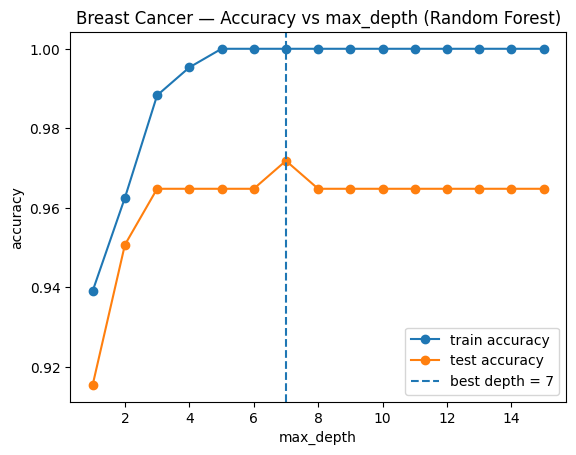

Best depth by test accuracy: 7


In [15]:
depths = list(range(1, 16))
train_accs = []
test_accs = []

for d in depths:
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=d,
        max_features="sqrt",
        random_state=42,
    ).fit(X_train_std, y_train)
    train_accs.append(accuracy(y_train, clf.predict(X_train_std)))
    test_accs.append(accuracy(y_test, clf.predict(X_test_std)))

best_d_bc = depths[int(np.argmax(test_accs))]

plt.figure()
plt.plot(depths, train_accs, marker="o", label="train accuracy")
plt.plot(depths, test_accs, marker="o", label="test accuracy")
plt.axvline(best_d_bc, linestyle="--", label=f"best depth = {best_d_bc}")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Breast Cancer — Accuracy vs max_depth (Random Forest)")
plt.legend()
plt.show()

print("Best depth by test accuracy:", best_d_bc)


### 4.3 Sweep `n_estimators` (forest)

More trees typically reduce variance and stabilize test performance.

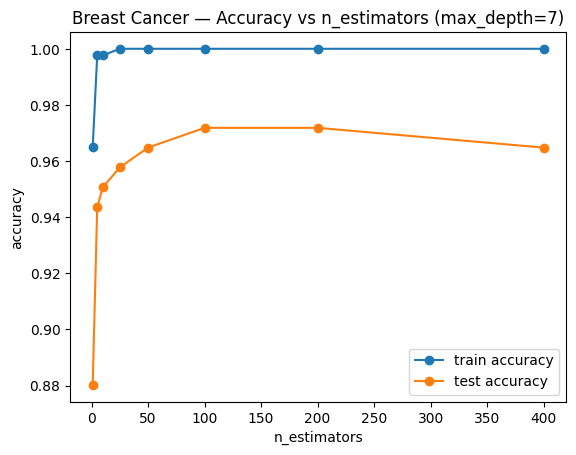

In [16]:
n_list = [1, 5, 10, 25, 50, 100, 200, 400]
train_accs_n = []
test_accs_n = []

for n_estimators in n_list:
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=best_d_bc,
        max_features="sqrt",
        random_state=42,
    ).fit(X_train_std, y_train)
    train_accs_n.append(accuracy(y_train, clf.predict(X_train_std)))
    test_accs_n.append(accuracy(y_test, clf.predict(X_test_std)))

plt.figure()
plt.plot(n_list, train_accs_n, marker="o", label="train accuracy")
plt.plot(n_list, test_accs_n, marker="o", label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.title(f"Breast Cancer — Accuracy vs n_estimators (max_depth={best_d_bc})")
plt.legend()
plt.show()


### 4.4 Compare `max_features` settings (forest)

Forests often benefit from restricting features per split (decorrelation).

In [17]:
settings = [
    ("all (None)", None),
    ("sqrt(p)", "sqrt"),
    ("log2(p)", "log2"),
    ("0.3*p", 0.3),
]

rows = []
for name, mf in settings:
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=best_d_bc,
        max_features=mf,
        random_state=42,
    ).fit(X_train_std, y_train)
    rows.append([
        name,
        mf,
        accuracy(y_train, clf.predict(X_train_std)),
        accuracy(y_test, clf.predict(X_test_std)),
    ])

print("setting\tmax_features\ttrain_acc\ttest_acc")
for r in rows:
    print(f"{r[0]}\t{r[1]}\t{r[2]:.4f}\t{r[3]:.4f}")


setting	max_features	train_acc	test_acc
all (None)	None	1.0000	0.9718
sqrt(p)	sqrt	1.0000	0.9718
log2(p)	log2	1.0000	0.9648
0.3*p	0.3	1.0000	0.9718


## 5. Part C — Regression (Diabetes)

We compare a single regression tree vs a random forest regressor using **RMSE** and **R²**.

To keep runtimes reasonable and match earlier notebooks, we use **5 features** (the first 5).

In [18]:
diab = load_diabetes()
X = diab.data[:, :5]  # 5 features
y = diab.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    shuffle=True,
    random_state=42,
)

X_train_std, params = standardize(X_train, return_params=True)
mean = params["mean"]
scale = params["scale"]
X_test_std = (X_test - mean) / scale

print("Train mean (approx):", np.round(X_train_std.mean(axis=0), 4))
print("Train std  (approx):", np.round(X_train_std.std(axis=0), 4))
print("Test  mean (approx):", np.round(X_test_std.mean(axis=0), 4))
print("Test  std  (approx):", np.round(X_test_std.std(axis=0), 4))


Train mean (approx): [ 0.  0.  0. -0. -0.]
Train std  (approx): [1. 1. 1. 1. 1.]
Test  mean (approx): [ 0.2195  0.109   0.0674  0.0849 -0.1043]
Test  std  (approx): [1.1416 1.0039 0.9997 0.8715 0.9182]


### 5.1 Baselines: mean predictor, single tree, random forest

In [19]:
# Mean baseline (predict training mean)
baseline_pred = np.full_like(y_test, float(np.mean(y_train)))
print("Mean baseline")
print("  test  RMSE:", rmse(y_test, baseline_pred))
print("  test  R^2 :", r2_score(y_test, baseline_pred))

# Single regression tree
tree = RegressionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=42).fit(X_train_std, y_train)
pred_tree_train = tree.predict(X_train_std)
pred_tree_test = tree.predict(X_test_std)

print("\nRegressionTreeRegressor | max_depth=5, min_samples_leaf=5")
print("  train RMSE:", rmse(y_train, pred_tree_train))
print("  test  RMSE:", rmse(y_test, pred_tree_test))
print("  train R^2 :", r2_score(y_train, pred_tree_train))
print("  test  R^2 :", r2_score(y_test, pred_tree_test))

# Random forest regressor
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
).fit(X_train_std, y_train)

pred_rf_train = rf.predict(X_train_std)
pred_rf_test = rf.predict(X_test_std)

print("\nRandomForestRegressor | n_estimators=300, max_depth=5, min_samples_leaf=5")
print("  train RMSE:", rmse(y_train, pred_rf_train))
print("  test  RMSE:", rmse(y_test, pred_rf_test))
print("  train R^2 :", r2_score(y_train, pred_rf_train))
print("  test  R^2 :", r2_score(y_test, pred_rf_test))


Mean baseline
  test  RMSE: 74.92989610400798
  test  R^2 : -0.016226638620203904

RegressionTreeRegressor | max_depth=5, min_samples_leaf=5
  train RMSE: 51.36502426149171
  test  RMSE: 74.75377969243598
  train R^2 : 0.5633128598142998
  test  R^2 : -0.011455142425709441

RandomForestRegressor | n_estimators=300, max_depth=5, min_samples_leaf=5
  train RMSE: 49.2736235868151
  test  RMSE: 64.21280137622185
  train R^2 : 0.5981495947788421
  test  R^2 : 0.2536826323260978


### 5.2 Sweep `max_depth` (forest)

We choose `best_depth` by **minimum test RMSE**.

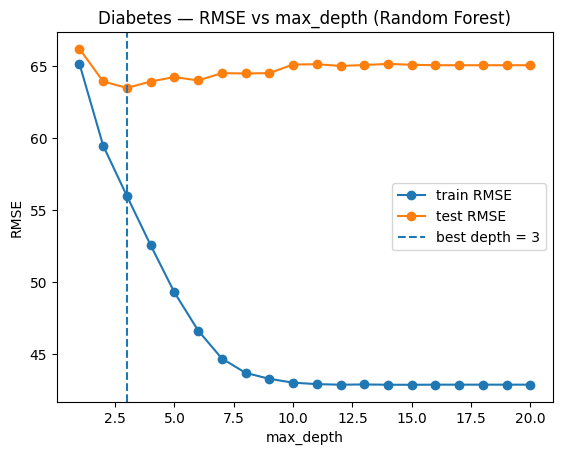

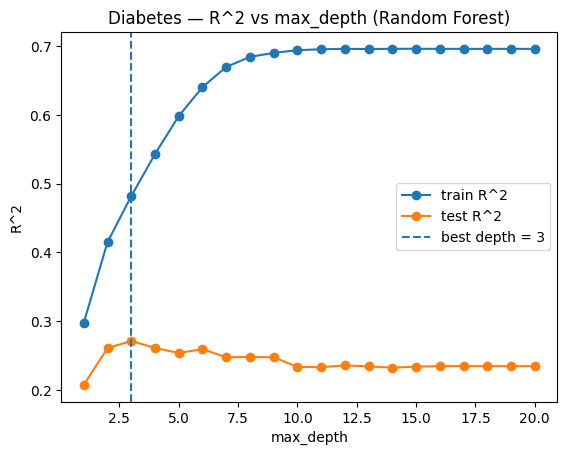

Best depth by test RMSE: 3


In [20]:
depths = list(range(1, 21))
train_rmse = []
test_rmse = []
train_r2 = []
test_r2 = []

for d in depths:
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=d,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=42,
    ).fit(X_train_std, y_train)

    pr_tr = model.predict(X_train_std)
    pr_te = model.predict(X_test_std)

    train_rmse.append(rmse(y_train, pr_tr))
    test_rmse.append(rmse(y_test, pr_te))
    train_r2.append(r2_score(y_train, pr_tr))
    test_r2.append(r2_score(y_test, pr_te))

best_d = depths[int(np.argmin(test_rmse))]

plt.figure()
plt.plot(depths, train_rmse, marker="o", label="train RMSE")
plt.plot(depths, test_rmse, marker="o", label="test RMSE")
plt.axvline(best_d, linestyle="--", label=f"best depth = {best_d}")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.title("Diabetes — RMSE vs max_depth (Random Forest)")
plt.legend()
plt.show()

plt.figure()
plt.plot(depths, train_r2, marker="o", label="train R^2")
plt.plot(depths, test_r2, marker="o", label="test R^2")
plt.axvline(best_d, linestyle="--", label=f"best depth = {best_d}")
plt.xlabel("max_depth")
plt.ylabel("R^2")
plt.title("Diabetes — R^2 vs max_depth (Random Forest)")
plt.legend()
plt.show()

print("Best depth by test RMSE:", best_d)


### 5.3 Sweep `min_samples_leaf` (forest, fixed depth)

Larger leaf sizes regularize the forest and can improve generalization on noisy data.

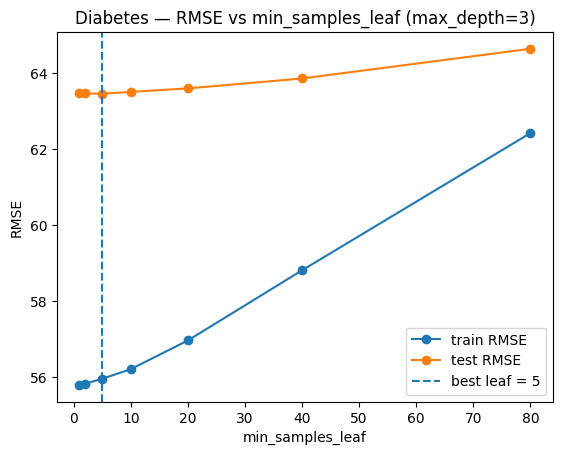

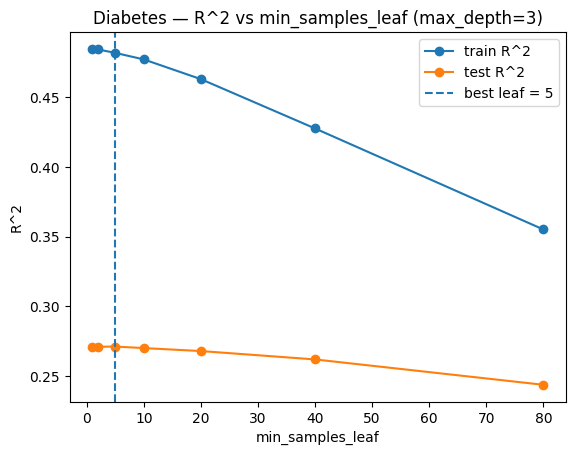

Best min_samples_leaf (with best_depth): 5


In [21]:
leaves = [1, 2, 5, 10, 20, 40, 80]
train_rmse_l = []
test_rmse_l = []
train_r2_l = []
test_r2_l = []

for leaf in leaves:
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=best_d,
        min_samples_leaf=leaf,
        max_features="sqrt",
        random_state=42,
    ).fit(X_train_std, y_train)

    pr_tr = model.predict(X_train_std)
    pr_te = model.predict(X_test_std)

    train_rmse_l.append(rmse(y_train, pr_tr))
    test_rmse_l.append(rmse(y_test, pr_te))
    train_r2_l.append(r2_score(y_train, pr_tr))
    test_r2_l.append(r2_score(y_test, pr_te))

best_leaf = leaves[int(np.argmin(test_rmse_l))]

plt.figure()
plt.plot(leaves, train_rmse_l, marker="o", label="train RMSE")
plt.plot(leaves, test_rmse_l, marker="o", label="test RMSE")
plt.axvline(best_leaf, linestyle="--", label=f"best leaf = {best_leaf}")
plt.xlabel("min_samples_leaf")
plt.ylabel("RMSE")
plt.title(f"Diabetes — RMSE vs min_samples_leaf (max_depth={best_d})")
plt.legend()
plt.show()

plt.figure()
plt.plot(leaves, train_r2_l, marker="o", label="train R^2")
plt.plot(leaves, test_r2_l, marker="o", label="test R^2")
plt.axvline(best_leaf, linestyle="--", label=f"best leaf = {best_leaf}")
plt.xlabel("min_samples_leaf")
plt.ylabel("R^2")
plt.title(f"Diabetes — R^2 vs min_samples_leaf (max_depth={best_d})")
plt.legend()
plt.show()

print("Best min_samples_leaf (with best_depth):", best_leaf)


### 5.4 Compare `max_features` settings (forest)

For regression forests, feature subsampling can still help by decorrelating trees, but the best choice is dataset-dependent.

In [22]:
settings = [
    ("all (None)", None),
    ("sqrt(p)", "sqrt"),
    ("0.3*p", 0.3),
]

rows = []
for name, mf in settings:
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=best_d,
        min_samples_leaf=best_leaf,
        max_features=mf,
        random_state=42,
    ).fit(X_train_std, y_train)

    pr_tr = model.predict(X_train_std)
    pr_te = model.predict(X_test_std)

    rows.append([
        name,
        mf,
        rmse(y_train, pr_tr),
        rmse(y_test, pr_te),
        r2_score(y_train, pr_tr),
        r2_score(y_test, pr_te),
    ])

print("setting\tmax_features\ttrain_RMSE\ttest_RMSE\ttrain_R2\ttest_R2")
for r in rows:
    print(f"{r[0]}\t{r[1]}\t{r[2]:.4f}\t{r[3]:.4f}\t{r[4]:.4f}\t{r[5]:.4f}")


setting	max_features	train_RMSE	test_RMSE	train_R2	test_R2
all (None)	None	54.7866	64.3568	0.5032	0.2503
sqrt(p)	sqrt	55.9579	63.4582	0.4817	0.2711
0.3*p	0.3	60.0398	64.5848	0.4034	0.2450


## 6. Part D — 1D synthetic regression (visual intuition)

Regression forests average many piecewise-constant trees, which often produces a **less jagged** function than a single deep tree.

In [23]:
rng = np.random.default_rng(0)
n = 300
x = rng.uniform(-3.0, 3.0, size=n)
y = np.sin(x) + 0.15 * rng.normal(size=n)

X1 = x.reshape(-1, 1)

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y,
    test_size=0.25,
    shuffle=True,
    random_state=42,
)

X1_train_std, params1 = standardize(X1_train, return_params=True)
mean1 = params1["mean"]
scale1 = params1["scale"]
X1_test_std = (X1_test - mean1) / scale1

print("X1_train shape:", X1_train.shape, "X1_test shape:", X1_test.shape)
print("Train mean (approx):", np.round(X1_train_std.mean(axis=0), 6))
print("Train std  (approx):", np.round(X1_train_std.std(axis=0), 6))


X1_train shape: (225, 1) X1_test shape: (75, 1)
Train mean (approx): [-0.]
Train std  (approx): [1.]


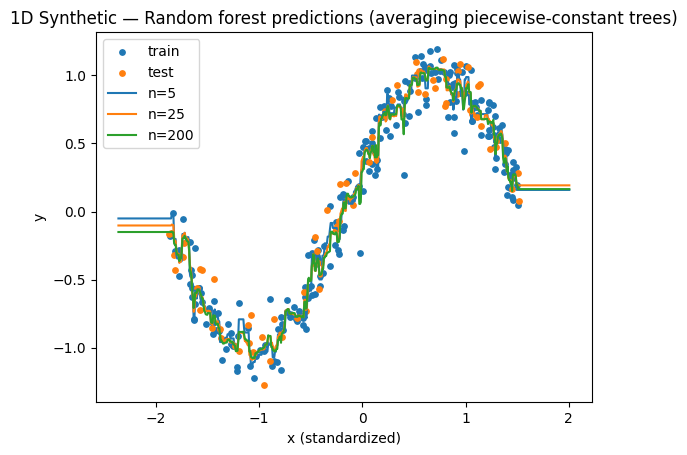

In [24]:
grid = np.linspace(X1_train_std.min() - 0.5, X1_train_std.max() + 0.5, 600).reshape(-1, 1)

plt.figure()
plt.scatter(X1_train_std[:, 0], y1_train, s=15, label="train")
plt.scatter(X1_test_std[:, 0], y1_test, s=15, label="test")

configs = [
    ("n=5", 5),
    ("n=25", 25),
    ("n=200", 200),
]
for label, n_estimators in configs:
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=8,
        min_samples_leaf=2,
        max_features=None,  # 1D
        random_state=0,
    ).fit(X1_train_std, y1_train)
    plt.plot(grid[:, 0], model.predict(grid), label=label)

plt.xlabel("x (standardized)")
plt.ylabel("y")
plt.title("1D Synthetic — Random forest predictions (averaging piecewise-constant trees)")
plt.legend()
plt.show()


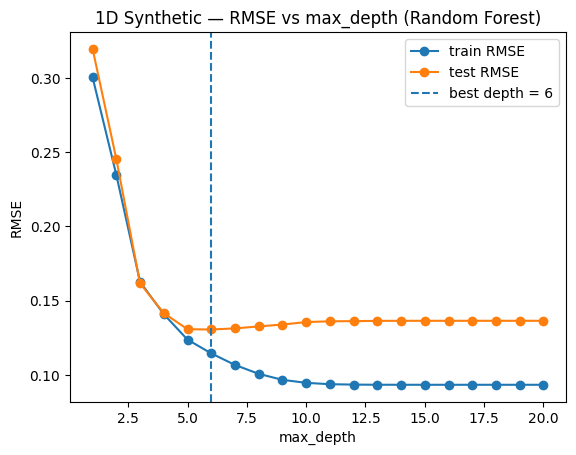

Best depth by test RMSE (synthetic): 6


In [25]:
depths = list(range(1, 21))
test_rmse = []
train_rmse = []

for d in depths:
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=d,
        min_samples_leaf=2,
        max_features=None,
        random_state=0,
    ).fit(X1_train_std, y1_train)

    train_rmse.append(rmse(y1_train, model.predict(X1_train_std)))
    test_rmse.append(rmse(y1_test, model.predict(X1_test_std)))

best_d_syn = depths[int(np.argmin(test_rmse))]

plt.figure()
plt.plot(depths, train_rmse, marker="o", label="train RMSE")
plt.plot(depths, test_rmse, marker="o", label="test RMSE")
plt.axvline(best_d_syn, linestyle="--", label=f"best depth = {best_d_syn}")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.title("1D Synthetic — RMSE vs max_depth (Random Forest)")
plt.legend()
plt.show()

print("Best depth by test RMSE (synthetic):", best_d_syn)


## 7. Conclusion

In this notebook we implemented **RandomForestClassifier** and **RandomForestRegressor** and compared them against single-tree baselines. The experiments highlight why bagging + feature subsampling typically improves generalization for tree-based models.

### 1) Random Forest Classification

**Iris (2D features)**  
- With a moderate depth (e.g., `max_depth=3`), the random forest achieved **train acc ≈ 0.982** and **test acc ≈ 0.917**. The confusion matrix shows **setosa is perfectly classified**, and the remaining mistakes come from **versicolor vs. virginica**, which are inherently overlapping in this 2D feature space.
- As `max_depth` increases, **training accuracy quickly approaches 1.0**, while **test accuracy peaks and then plateaus** (best depth around **5** in our sweep). This reflects the usual pattern: deeper trees increase model capacity, but the ensemble only benefits up to a point on this relatively small dataset.
- Changing `n_estimators` improves stability but shows **diminishing returns**: once the forest is large enough, test accuracy becomes essentially flat.
- **Feature subsampling helps**: using `max_features="sqrt"` (or `0.3*p`) improved test accuracy to about **0.944**, while using all features did not improve performance on Iris 2D. This is consistent with the random forest idea: injecting randomness decorrelates trees and improves the ensemble average.

**Breast Cancer (30D features)**  
- Compared to a single decision tree, the random forest generalizes better. In our run:
  - **DecisionTreeClassifier (max_depth=5)**: test acc ≈ **0.908**
  - **RandomForestClassifier (n_estimators=300, max_depth=5, max_features="sqrt")**: test acc ≈ **0.965**
- This is the core advantage of random forests: even though each tree can overfit (and train accuracy often reaches 1.0), averaging many decorrelated trees reduces variance and boosts test performance.
- For `max_features`, several reasonable settings (all / sqrt / 0.3*p) performed similarly here (around **0.972**), while overly restrictive feature choices can slightly reduce performance (`log2` was a bit lower in our run).

**Scaling check (raw vs standardized)**  
- As expected, standardizing features did not change performance on Iris (same test accuracy) and even produced **identical predictions** in this run. This supports the practical guideline that **tree-based models are largely insensitive to feature scaling**, although we still keep a consistent preprocessing pipeline to avoid leakage and maintain a uniform workflow across models.

### 2) Random Forest Regression (Diabetes)

- The regression results show a clear improvement over simpler baselines:
  - **Mean baseline**: test RMSE ≈ **74.93**, test R² ≈ **-0.016**
  - **Single regression tree (max_depth=5, leaf=5)**: test RMSE ≈ **74.75**, test R² ≈ **-0.011** (little improvement, and still worse than predicting the mean in R² terms)
  - **RandomForestRegressor (300 trees, max_depth=5, leaf=5)**: test RMSE ≈ **64.21**, test R² ≈ **0.254**
- The sweep over `max_depth` shows the familiar behavior: training error decreases steadily with depth, but **test RMSE is minimized at a relatively shallow depth** (best depth around **3**), after which deeper trees add complexity without improving generalization.
- The sweep over `min_samples_leaf` indicates mild regularization can help, but **too-large leaf sizes underfit**; in our run the best test RMSE occurred at a **small leaf size (≈ 5)**.

### 3) 1D Synthetic intuition (why averaging helps)

- **Averaging many piecewise-constant trees produces a smoother function.**  
  In the 1D synthetic plot, each individual tree is still piecewise-constant, but the **random forest prediction becomes progressively smoother** as `n_estimators` increases (compare `n=5` vs `n=25` vs `n=200`). This is a visual demonstration of variance reduction: averaging many “noisy” learners cancels out unstable fluctuations while preserving the underlying signal.

- **More trees mainly improves stability, not the fundamental bias level.**  
  Increasing `n_estimators` reduces the jaggedness and makes the prediction curve more consistent, but it does not necessarily change the best achievable error once the forest is large enough—consistent with the diminishing-returns pattern we saw in the classification experiments.

- **Depth tuning still matters even with an ensemble.**  
  The RMSE-vs-depth curve shows test RMSE decreases rapidly at first, reaches its best value around **`max_depth ≈ 6`**, and then slightly worsens/plateaus as depth grows.  
  This indicates that random forests reduce variance, but **they do not eliminate overfitting entirely**: overly deep trees can still fit noise, and the ensemble may inherit some of that high-variance behavior.

- **Overall takeaway from the synthetic example:**  
  Random forests can approximate nonlinear functions well because they combine many simple threshold-based models, and the averaging effect makes the final predictor **more stable and less jagged** than a single regression tree—while still requiring sensible regularization (depth/leaf size) for best generalization.


Random forests substantially reduce the variance of single trees by combining **bootstrap sampling (bagging)** with **feature subsampling**, leading to stronger and more stable test performance—especially on higher-dimensional datasets. They still require tuning (depth and leaf size), and while increasing the number of trees improves stability, it eventually yields diminishing returns.
